In [1]:
from kaiseki import lattice
from kaiseki import kakunou_kai
from kaiseki import Short_Algo_kai
from kaiseki import Long_kaiseki
import time
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import csv
import os
import random
import math

from scipy.spatial import distance
from scipy.optimize import linprog
from scipy.optimize import minimize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

In [2]:
E = 5
Col = 60

K = Col * Col

M = 50
N = 50

# Scaling * tが格子の最小距離となる。
Scaling = 10.0 / Col
alter_T_num = 0.5

city_network = lattice.make_lattice(Col)

#境界あり
# Coordinate_Data = \
# np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
#            city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
# distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

#境界なし
Periodic = lattice.MakePeriodicDistanceMatrix(Col, Scaling)
LatticeCal = lattice.LatticeCalculator(Col, Scaling, n=0)
Periodic.add_distance_row()
distance_matrix = Periodic.distance_matrix


In [97]:
# 通勤費用パラメータ
t = 0.1

# 距離抵抗パラメータ
tau = 0.5

# 総土地供給量
# S_total = K
# S_bar = S_total / K
S_total = 100
S_bar = S_total / K

theta_firm = 1.0
theta_house = 1.0

alpha_1 = 0.4
alpha_2 = 0.4
beta_1 = 0.4
beta_2 = 0.4

L = 0.2
eta = 1.2
p_proj = 1e-3

RW_ini = 1.0
RW_proj = 1e-3

err_short = 1e-5
err_long = 1e-3
obj_corr = 1.0

m_per = M / K
m0 = np.array([m_per] * K)
n0 = np.full((K, K), N / (K * K))

firm = np.zeros(K)
dist0 = np.zeros(K)
delta = list(np.zeros(K, dtype=int))

method = "FISTA"
dic = "Scaling=30"
#パラメータ設定
prm = Long_kaiseki.Parameter(Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
            theta_firm, theta_house, E, alpha_1, alpha_2, beta_1, beta_2, M, N)

long = Long_kaiseki.Long(prm)

In [98]:
import matplotlib.pyplot as plt
import io
from PIL import Image, ImageDraw
import numpy as np
from pptx import Presentation
from pptx.util import Inches

def m_image(prm, m, max_flag=True):
   
    Num_Cols = int(np.sqrt(prm.K))
    mat = np.reshape(m, (Num_Cols, Num_Cols))
    
    plt.figure(figsize=(5,5))
    if max_flag:
        plt.imshow(mat, interpolation='nearest', vmin=0.0, vmax=prm.S_bar, cmap='Reds')
    else:
        plt.imshow(mat, interpolation='nearest', cmap='Reds')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    
    return Image.open(buf)

In [109]:
S = 0.05
# 企業の初期立地パターンを設定する関数
def set_initial_pattern(init, alpha=0.0):
    center = [K//2+Col//2, #真ん中（空間の中心）
              0, #左上角
              Col//2, #上端，下端
              K//2, #中央右端，中央左端
              Col//4+K//4, 
              3*Col//4+K//4,
              Col//4+3*K//4,
              3*Col//4+3*K//4,
              Col//4,
              3*Col//4,
              K//4,
              3*K//4,
              Col//2+K//4,
              Col//4+K//2,
              3*Col//4+K//2,
              Col//2+3*K//4]

    firm.fill(0.0)
    
    if init in [-1, -2]:
        # ファイルから読み込み (仮にファイル処理は無視)
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: ファイルから")
        filename = f"input{-init}.txt"
        try:
            with open(filename, "r") as file:
                for i in range(K):
                    firm[i] = float(file.readline())
        except FileNotFoundError:
            print("File Open Failed.")
            return

    elif init == 0:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: 一様分布")
        firm.fill(M/K)

    elif init in [1, 2, 4, 8, 16]:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: {init}極集中")
        area = M // S // init
        ai = int(area)
        # print("init:", init)
        # print("ai:", ai)
        print("area-ai:", area - ai)
        for cnt in range(init):
            i = center[cnt] #iはノード番号
            for y in range(ai):
                j = int(((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col)
                # print("j:", j)
                firm[j] = S
            
            print("y:", y)
            # firm[y] = (area - ai) * S

    elif init == 3:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: 二極と四極(a = {alpha})")
        for cnt in range(2):
            i = center[cnt]
            for y in range(int(M / S / 2)):
                j = ((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col
                firm[j] += S * (1.0 - alpha)
        for cnt in range(4):
            i = center[cnt]
            for y in range(int(M / S / 4)):
                j = ((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col
                firm[j] += S * alpha

    else:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: ランダム")
        m = M
        x = S
        random.seed()
        while m > Epsilon:
            i = random.randint(0, K-1)
            if firm[i] <= S - x:
                firm[i] += x
                m -= x

# 距離計算 (仮実装)
def distance(i, j):
    return abs(i - j)

# Z1の計算
def calc_Z1(init):
    Z1 = 0.0
    if init == 0:
        for i in range(K):
            Z1 -= 0.5 * np.exp(-tau * distance(i, 0)) * firm[i] * firm[0]
        Z1 *= K
    elif init in [1, 2, 4, 8, 16]:
        c = K // 2 + Col // 2
        for i in range(K):
            for y in range(int(M / S / init)):
                j = ((delta[y] // Col + c // Col) % Col) * Col + (c % Col + delta[y] % Col) % Col
                Z1 -= 0.5 * np.exp(-tau * distance(i, j)) * firm[i] * firm[j]
        Z1 *= init
    else:
        for i in range(K):
            for j in range(K):
                Z1 -= 0.5 * np.exp(-tau * distance(i, j)) * firm[i] * firm[j]
    return Z1

# 近似目的関数
def rough_potential(init):
    Z1 = calc_Z1(init)
    Z2 = 0.0
    if init == 0:
        Z2 = 0.0
    elif init in [1, 2, 4, 8, 16]:
        Z2 = 0.1165 * t / math.sqrt(init)
    else:
        Z2 = t * obj_sub
    return Z1 + Z2


def set_delta():
    for i in range(K):
        delta[i] = i
        dist0[i] = LatticeCal.calc_distance(0, i)
    delta.sort(key=lambda x: dist0[x])

In [110]:
set_delta()

In [129]:
set_initial_pattern(init=2)

tau = 0.500, t = 0.100, 初期立地: 2極集中
area-ai: 0.0
y: 498
y: 498


In [130]:
firm

array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05])

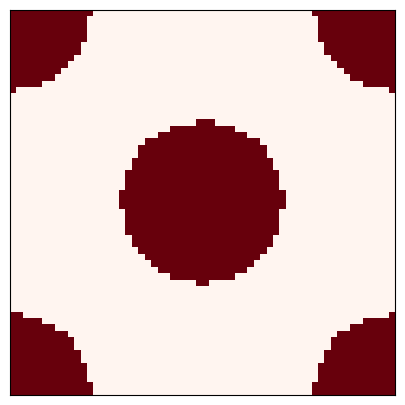

In [131]:
m_image(prm, firm)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# senbun_potential関数の定義が必要
def senbun_potential(t, tau, M, L, SF, SH, N):
    # ここでのポテンシャル計算を実装
    # とりあえずダミーのポテンシャル値を返します
    return 0, np.random.random()  # 仮のポテンシャル計算

# パラメータ
M = 100  # 企業数
L = 0.5  # 線分の長さ
SF = 1
SH = 1

# forループの刻み幅
h_i = 0.001  # tauの刻み幅
i = 1  # tau軸の上限
h_it = 0.0005  # tの刻み幅
it = 0.5  # t軸の上限
N = 25  # 極数の上限

# tauとtの範囲
tau = np.arange(h_i, i + h_i, h_i)
t = np.arange(it, -h_it, -h_it)

# 結果格納用の行列
c = np.zeros((len(t), len(tau)))

# ポテンシャル計算を並列化
def calculate_potential(count_tau):
    tau_tmp = tau[count_tau]
    c_ind = np.zeros(len(t))
    
    for count_t in range(len(t)):
        #1つめの戻り値を無視する，という書き方
        _, c_ind[count_t] = senbun_potential(t[count_t], tau_tmp, M, L, SF, SH, N)
    
    return c_ind

# 並列処理で計算
results = Parallel(n_jobs=-1)(delayed(calculate_potential)(count_tau) for count_tau in range(len(tau)))

# 結果を行列に代入
for count_tau, c_ind in enumerate(results):
    #cの列ごとに，c_indを格納する
    c[:, count_tau] = c_ind

# プロット
X, Y = np.meshgrid(tau, t)
plt.contour(X, Y, c, N + 1, colors='r')
plt.xlabel('企業間交通費用 τ')
plt.ylabel('通勤費用 t')
plt.title(f'M = {M}, L = {L}, S_F = {SF}, S_H = {SH}')
plt.show()

# 結果をファイルに保存
# np.savetxt('jikken0827_1.csv', c, delimiter=",")
# plt.savefig('jikken0827_1.png')  # 画像として保存

In [7]:
A = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

A[0, :]

array([1, 2, 3])